In [9]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from src import utils, load_data
from src.models import lth
from tqdm.notebook import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.utils.tensorboard import SummaryWriter

print(f"found gpu: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
found gpu: True


In [10]:
dataset = load_data.cifar10({"batch_size": 60})

train, val, test = dataset
images, labels = next(iter(train))

grid = torchvision.utils.make_grid(images)
with SummaryWriter(f'tensorboard/cifar10') as writer:
    writer.add_image('processed', grid, 1)
    writer.flush()

Files already downloaded and verified
Files already downloaded and verified


In [11]:
layer_definitions = [
    ("conv", {"out": 64, "bn": True}), 
    ("relu", {}),
    ("conv", {"out": 64, "bn": True}), 
    ("relu", {}),
    ("pool", {}), 

    ("conv", {"out": 128, "bn": True}), 
    ("relu", {}),
    ("conv", {"out": 128, "bn": True}), 
    ("relu", {}),
    ("pool", {}),

    ("conv", {"out": 256, "bn": True}), 
    ("relu", {}),
    ("conv", {"out": 256, "bn": True}), 
    ("relu", {}),
    ("pool", {}),

    ("flatten", {}), 

    ("linear", {"out": 256}), 
    ("relu", {}),

    ("linear", {"out": 256}), 
    ("relu", {}),

    ("linear", {"out": 10})
]

expr_params = {
    "prune_strategy": {
        "name": "global",
        "rate": .1,
        "iterations": 35,
    },
    "expr_id": utils.new_expr_id("cifar10 vgg lth"),
    "model_training_params": {
        "optimizer": ("adam", {"lr": 0.0001}),
        "loss_func": "cross_entropy",
        "training_iterations": 30,
        "early_stopping": False,
        "model_name": "VGG",
        "dataset_name": "cifar10",
        "layer_definitions": layer_definitions
    }
}

print(f"starting lth run {expr_params['expr_id']}")
mask = lth.run(dataset, expr_params)

starting lth run expr 2020-11-05 | 08:02:07 cifar10 vgg lth zv6hH
starting prune iteration 0


early stopping triggered at epoch 12

0. perc_left: 1.0, test_acc 0.7505
starting prune iteration 1


KeyboardInterrupt: 

In [ ]:
plt.clf()
accs = [log["test_acc"] for log in logs]
plt.plot(accs)
plt.xlabel("prune_iter")
plt.ylabel("test_acc")
plt.title("acc over pruning iterations")
plt.show()

In [ ]:
dataset = load_data.cfar10({"batch_size": 400})
train_data, val_data, test_data = dataset
print(test_data.dataset)
datapoint = test_data.dataset[0]
X, y = datapoint
print(X.shape)

torch.Size([3, 32, 32])


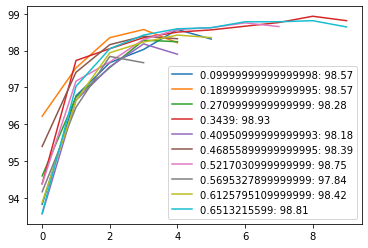

In [42]:
plt.clf()
for log in logs:
    accs = log["val_accs"]
    pr = log["prune_rate"]
    plt.plot(accs, label=f"{pr}: {max(accs)}")
plt.legend()
plt.show()

In [36]:
print(next(model.named_parameters())[1])
# print(initial_weights[0][1])

In [28]:
mask = lth.build_mask(model)

In [53]:
lth.update_mask(model, mask, .95)
lth.prune_model(model, mask)
print(mask.keys())
weights = [weight for name, weight in mask.items() if "weight" in name]
print([(weight.sum().to(torch.float32), np.prod(weight.shape)) for weight in weights])

dict_keys(['features.0.weight', 'features.2.weight', 'classifier.0.weight', 'classifier.2.weight', 'classifier.4.weight'])
[(tensor(191.), 576), (tensor(4948.), 36864), (tensor(146025.), 3211264), (tensor(13697.), 65536), (tensor(978.), 2560)]


In [31]:
mask = lth.ModelMask(model)
feature0 = next(model.named_parameters())
name, weight = feature0
print(weight.shape)
print(mask.bit_mask[name].shape)

torch.Size([64, 1, 3, 3])
torch.Size([64, 1, 3, 3])


In [41]:
num_weights = 0
for name, parameter in model.named_parameters():
    if "weight" in name:
        print(parameter.shape)
        num_weights += np.prod(parameter.shape)

all_weights = np.empty(shape=num_weights, dtype=np.float32)
i = 0
for name, parameter in model.named_parameters():
    if "weight" in name:
        num_weights = np.prod(parameter.shape)
        all_weights[i:i+num_weights]parameter.data().flatten().numpy().astype(np.float32)
        cur_index += num_weights
        
print()

torch.Size([64, 1, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([256, 12544])
torch.Size([256, 256])
torch.Size([10, 256])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [17]:
prune_rate = .5

named_parameters = [
    ("weight0", torch.arange(5, dtype=torch.int32).to(device)),
    ("weight1", torch.arange(20, 40, dtype=torch.int32).to(device))
]

weight_parameters = [parameter for name, parameter in named_parameters if "weight" in name]
all_weights = [parameter.flatten().cpu().numpy().astype(np.float32) for parameter in weight_parameters]
all_weights = np.concatenate(all_weights)

num_weights = len(all_weights)
k = int(num_weights*prune_rate)
kth_weight = np.partition(all_weights, k)[k]

mask = {}
for name, parameter in named_parameters:
    if "weight" in name:
        mask[name] = parameter*(parameter > kth_weight)
print(mask)
print(named_parameters[0][1].dtype)

{'weight0': tensor([0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32), 'weight1': tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39], device='cuda:0', dtype=torch.int32)}
torch.int32


In [59]:
np.concatenate((np.array([1, 2, 3], dtype=np.float32), np.array([[1, 1], [2,1], [3,3]], dtype=np.float32).flatten()))

array([1., 2., 3., 1., 1., 2., 1., 3., 3.], dtype=float32)

In [82]:
a = torch.ones_like(named_parameters[0][1], dtype=torch.bool).to(device)
print(a, a.dtype)

tensor([True, True, True, True, True], device='cuda:0') torch.bool


In [88]:
a.set_(torch.from_numpy(np.array([False, False, False, False, False])).to(device))

tensor([False, False, False, False, False], device='cuda:0')

In [96]:
tensor = torch.abs(torch.tensor([1, 4, 3, 5, 6, 9, 7]))*-1
values, indices = torch.topk(tensor, 3, sorted=True)
print(tensor)
values[-1]

tensor([-1, -4, -3, -5, -6, -9, -7])


tensor(-4)

In [6]:
bigtensor = torch.ones(size=(250000000,), device=device, dtype=torch.int32)

In [7]:
mask = (bigtensor.cpu() > 4)

In [9]:
bigtensor = bigtensor * mask.to("cuda")

In [10]:
bigtensor = torch.abs(bigtensor)
# bigtensor = torch.zeros(size=(250000000,), device=device, dtype=torch.int32)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [62]:
a = torch.tensor([2., 3., 4.], requires_grad=True)
b = torch.prod(a)
d = b+2
# a.retain_grad()
b.retain_grad()
# c.retain_grad()
d.retain_grad()
d.backward(torch.tensor([5]))

# a.backward()

In [63]:
print([i.grad for i in [a, b]])

[tensor([60., 40., 30.]), tensor(5.)]
